# Load modules

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool
import re
import requests
import os
import pickle

# Aux functions

In [2]:
import glob
import random
import base64

from PIL import Image
from io import BytesIO
from IPython.display import HTML
import io

def get_thumbnail(path):
    path = "\\\\?\\"+path # This "\\\\?\\" is used to prevent problems with long Windows paths
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def link_formatter(listset):    
    
    li = []
    if len(listset) > 1 :
        for i in listset : 
            alist = i.split(",")
            if len(alist) > 1 :
                for a in alist :                     
                    li.append(a)
            else :
                li.append(alist[0])
    else :         
        li.append(list(listset)[0])

    pset = set(li)
    tag = '<ul>'    
        
    for a in pset :
        aset = a.split(",")
        if len(aset) > 1 :
            for i in aset :
                if re.search(".+/(MolPort.+)", i) :                                 
                    tag += f'<li><a href="{i}">Molport</a></li>'
                else :
                    tag += f'<li><a href="{i}">Hit2Lead</a></li>'
        else :
            if re.search(".+/(MolPort.+)", a) :                                 
                tag += f'<li><a href="{a}">Molport</a></li>'
            else :
                tag += f'<li><a href="{a}">Hit2Lead</a></li>'                        
    tag +='</ul>'
    return tag    

def set_formatter(aset):    
    
    tag = '<ul style="text-align:left;">'
    for a in aset :
        tag += f'<li>{a}</li>'
    tag +='</ul>'
    return tag   


def countCarbons(smiles) :
    pattern = '[cC]'
    carbons = len(re.findall(pattern, smiles))
    return carbons

def fragmentedMols(smiles) :     
    pattern = '\.'
    try : 
        fragments = len(re.findall(pattern, smiles))
        return fragments
    except :
        return np.nan

def safe_molFromSmiles(smiles) : 
    try :
        mol = Chem.MolFromSmiles(smiles)
        return mol
    except :
        return np.nan
    
def safe_removeSalts(mol) :
    try :
        mol = SaltRemover().StripMol(mol,dontRemoveEverything=True)
    except : 
        mol = np.nan
    return mol

def safe_mol_to_inchi(mol) :
    try :
        inchi = MolToInchi(mol)
    except : 
        inchi = np.nan
    return inchi

def safe_inchi_to_inchikey(inchi) :
    try :
        inchikey = InchiToInchiKey(inchi)
    except : 
        inchikey = np.nan
    return inchikey    
    
def SDF2DF (file=None,sanitize=True):
    
    mols= Chem.SDMolSupplier(file)
    df = pd.DataFrame()
    
    for mol in mols :
        
        try :
        
            mol_df = pd.DataFrame(mol.GetPropsAsDict(), index=[0])
            df = df.append(mol_df, ignore_index=True)
        except :
            next
        
    return df



def drugNames (smiles) :
    
    if re.search("\.",smiles) :
    
        smiles = smiles.split("\.")[0]
    
    url = "https://cactus.nci.nih.gov/chemical/structure/{}/names".format(smiles)
    response = requests.get(url)
    
    if response.status_code == 200 :
        if response.text.split("\n")[0] == '<!DOCTYPE html>' : 
            return None
        else :
            return response.text.split("\n")
    else :
        return None

import requests
import pandas as pd
import math

def retrieve_price(mp_id,minimum) :
    
    print(mp_id)

    try :
        
        r = retrieve_mpdata(mp_id)
        t = []
        
        for prod in r["Screening Block Suppliers"] :
            prod = dict(prod)        
            try : 
                for catalog in prod["Catalogues"] :
                    try : 
                        for packing in catalog["Available Packings"] :
                            try : 
                                if packing["Measure"] != "mg" :
                                    continue
                                if packing["Amount"] < minimum :
                                    continue
                                t.append(pd.DataFrame.from_dict(packing, orient="index").transpose())
                            except : 
                                continue
                    except : 
                        continue
            except : 
                continue  
                
        for prod in r['Building Block Suppliers'] :
            prod = dict(prod)        
            try : 
                for catalog in prod["Catalogues"] :
                    try : 
                        for packing in catalog["Available Packings"] :
                            try : 
                                if packing["Measure"] != "mg" :
                                    continue
                                if packing["Amount"] < minimum :
                                    continue                                    
                                t.append(pd.DataFrame.from_dict(packing, orient="index").transpose())
                            except : 
                                continue
                    except : 
                        continue
            except : 
                continue                     
        
        data = pd.concat(t)
        data["dist_to_min"] = data.apply(lambda x : x["Amount"]-minimum ,axis=1)        
        
        # Filtro por la presentación más conveniente
        data = data.iloc[data["dist_to_min"].argmin()]
        data["buy"] = math.ceil(minimum/data["Amount"])
        data["cost"] = data["Price"]*data["buy"]
        print(f"Min (mg): {minimum} mg \nPacking (mg) {data['Amount']}\nCantidad: {data['buy']}\nTotal: {data['cost']}")
        return data["cost"]
    except Exception as e:
        return f"Error API {e}"
    
def retrieve_mpdata(mp_id) :
    
    username = "john.spade"
    authcode = "fasdga34a3"
    
    url = f'http://api.molport.com/api/molecule/load?molecule={mp_id}&username={username}&authenticationcode={authcode}'
    r = requests.get(url)
    
    t = pd.DataFrame.from_dict(r.json()["Data"]).loc["Catalogues"]["Molecule"]
    

    return t    

 # Load datasets
 

In [3]:
# Set root 
root = ""

In [4]:
# Remove salts from molecules and replace <mol> with the cleaner version
from rdkit.Chem.SaltRemover import SaltRemover 
# Add Inchi and inchikeys to the molecules for further aggregation
from rdkit.Chem.inchi import MolToInchi
from rdkit.Chem.inchi import InchiToInchiKey

ndpi = pd.read_csv("ortholog-ndpi-library_notryp.csv",sep="\t")[['mol_id','smiles','known_target','known_target_product','known_target_species','gene_name']]
cherry_picked_targets = pd.read_csv("tcr_cherrypicked_routes.csv", sep="\t",)[["gene_name","gene_product"]]
tcr_targets_full = pd.read_csv("tcr_targest.csv",sep="\t")[["omcl","nds_tier","gene_name","gene_product"]]
ndpi = pd.merge(ndpi,tcr_targets_full,how="inner",on="gene_name")


In [5]:
len(ndpi['mol_id'].unique())

180023

In [6]:
ndpi["mol"] = ndpi.apply(lambda x : safe_molFromSmiles(x["smiles"]),axis=1)
ndpi["mol"] = ndpi.apply(lambda x: safe_removeSalts(x["mol"]),axis=1)
ndpi.drop(index=ndpi[ndpi["mol"]==np.nan].index,inplace=True)
ndpi["inchi"] = ndpi.apply(lambda x: safe_mol_to_inchi(x["mol"]),axis=1)
ndpi.drop(index=ndpi[ndpi["inchi"]==np.nan].index,inplace=True)
ndpi["inchikey"] = ndpi.apply(lambda x: safe_inchi_to_inchikey(x["inchi"]),axis=1)

In [7]:
compounds = ndpi.groupby(["inchikey","smiles","mol_id"]).agg({"mol":set}).reset_index()
compounds["smiles"].to_csv("compounds.smiles",index=False,header=False)

```MySQL
SELECT m.mol_id, g.gene_name AS known_target, g.gene_product AS known_target_product, g.species_code AS known_target_species, g2.gene_name, g.gene_product, g.nds_species_tier, m.smiles FROM moldata m JOIN gene_drug_interactions gdi on gdi.mol_id = m.mol_id JOIN genes g on g.gene_id = gdi.gene_id JOIN genes g2 on g.orthomcl_clusterid = g2.orthomcl_clusterid WHERE g2.species_code = 'tcr' AND m.mol_id NOT IN (SELECT xgdi.mol_id FROM gene_drug_interactions xgdi JOIN genes xg ON xg.gene_id = xgdi.gene_id WHERE xg.species_code IN ('tcr','tbr','lma') ) AND gdi.activity_tag = '+' GROUP BY gdi.mol_id;"
```

# Tested and Drugbank annotated drugs



In [8]:
li = []

files = {
    "TDR" :  '../Data/tested/tested.drugs.tryps.wupdate.smiles',
    "Nieves" :  '../Data/tested/tested.drugs.tryp.nieves.smiles',    
    "Fleau" :  '../Data/tested/tested.drugs.tryp.fleau.smiles',    
    
}

for src, filename in files.items():
    df = pd.read_csv(root+filename, sep="\t", names=["smiles"])[1:]
    df["source"] = src
    li.append(df)

tested = pd.concat(li, axis=0, ignore_index=True)
tested["mol"] = tested.apply(lambda x : Chem.MolFromSmiles(x["smiles"]),axis=1)

# Remove salts from molecules and replace <mol> with the cleaner version
from rdkit.Chem.SaltRemover import SaltRemover 
tested["mol"] = tested.apply(lambda x: SaltRemover().StripMol(x["mol"],dontRemoveEverything=True),axis=1)

# Add Inchi and inchikeys to the molecules for further aggregation
from rdkit.Chem.inchi import MolToInchi
from rdkit.Chem.inchi import InchiToInchiKey
tested["inchi"] = tested.apply(lambda x: MolToInchi(x["mol"]),axis=1)
tested["inchikey"] = tested.apply(lambda x: InchiToInchiKey(x["inchi"]),axis=1)

drugbank=SDF2DF("../Data/drugbank/structures.sdf")

C:\Users\lioneluranl\AppData\Local\Temp\ipykernel_17388\2882630777.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(mol_df, ignore_index=True)
C:\Users\lioneluranl\AppData\Local\Temp\ipykernel_17388\2882630777.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(mol_df, ignore_index=True)
C:\Users\lioneluranl\AppData\Local\Temp\ipykernel_17388\2882630777.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(mol_df, ignore_index=True)
C:\Users\lioneluranl\AppData\Local\Temp\ipykernel_17388\2882630777.py:118: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(mol_df, ignore_inde

In [9]:
drugbank_inset = pd.merge(ndpi,drugbank, left_on="inchikey", right_on="INCHI_KEY",how="inner")
drugbank_inset


mol_id                                             smiles  \
0         149   FCCn1cc(C(=O)O)c(=O)c2c1c(F)c(N1CCN(CC1)C)c(c2)F   
1        1621  NCC1CN(C/C/1=N\\OC)c1nc2c(cc1F)c(=O)c(cn2C1CC1...   
2       15337   NC1CCN(C1)c1c(F)cc2c(c1Cl)n(cc(c2=O)C(=O)O)C1CC1   
3       47954  CO[C@@H]1[C@@H](OC(=O)N)[C@@H](O)[C@@H](OC1(C)...   
4       57078             CCn1cc(C(=O)O)c(=O)c2c1cc(cc2)c1ccncc1   
...       ...                                                ...   
1874  1781133  Cc1nn(c(n1)c1cn2c(n1)c1ccc(cc1OCC2)c1cnn(c1)C(...   
1875  1270241  COc1cc2nccc(c2cc1C(=O)N)Oc1ccc(c(c1)Cl)NC(=O)N...   
1876  1142168                 O[C@@H]([C@H](C(=O)O)O)COP(=O)(O)O   
1877  1136223  C[C@H]([C@@H](C(=O)NS(=O)(=O)OC[C@H]1O[C@H]([C...   
1878  1216308  CCNC(=O)C[C@@H]1N=C(c2ccc(cc2)Cl)c2c(n3c1nnc3C...   

         known_target                               known_target_product  \
0               b3699                             DNA gyrase, subunit B    
1               b3699                             DNA gyrase, subunit B    
2               b3699                             DNA gyrase, subunit B    
3               b3699                             DNA gyrase, subunit B    
4               b3699                             DNA gyrase, subunit B    
...               ...                                                ...   
1874             5289  phosphatidylinositol 3-kinase, catalytic subun...   
1875  ENSG00000170759                           kinesin family member 5B   
1876  ENSG00000142657                    phosphogluconate dehydrogenase    
1877  ENSG00000113407                          threonyl-tRNA synthetase    
1878  ENSG00000156802            ATPase family, AAA domain containing 2    

     known_target_species         gene_name        omcl  nds_tier  \
0                     eco   TcCLB.506445.60  OG5_128755         5   
1                     eco   TcCLB.506445.60  OG5_128755         5   
2                     eco   TcCLB.506445.60  OG5_128755         5   
3                     eco   TcCLB.506445.60  OG5_128755         5   
4                     eco   TcCLB.506445.60  OG5_128755         5   
...                   ...               ...         ...       ...   
1874                  hsa  TcCLB.511903.160  OG5_128181         5   
1875                  hsa   TcCLB.506479.60  OG5_127646         3   
1876                  hsa  TcCLB.507011.269  OG5_127175         4   
1877                  hsa   TcCLB.511181.80  OG5_126764         3   
1878                  hsa  TcCLB.506297.110  OG5_128668         4   

                                           gene_product  \
0          mitochondrial DNA topoisomerase II, putative   
1          mitochondrial DNA topoisomerase II, putative   
2          mitochondrial DNA topoisomerase II, putative   
3          mitochondrial DNA topoisomerase II, putative   
4          mitochondrial DNA topoisomerase II, putative   
...                                                 ...   
1874           phosphatidylinositol 3-kinase vps34-like   
1875                      kinesin heavy chain, putative   
1876  6-phosphogluconate dehydrogenase, decarboxylating   
1877                 threonyl-tRNA synthetase, putative   
1878                                   ATPase, putative   

                                                    mol  ...  \
0     <rdkit.Chem.rdchem.Mol object at 0x0000028A134...  ...   
1     <rdkit.Chem.rdchem.Mol object at 0x0000028A729...  ...   
2     <rdkit.Chem.rdchem.Mol object at 0x0000028A103...  ...   
3     <rdkit.Chem.rdchem.Mol object at 0x0000028A102...  ...   
4     <rdkit.Chem.rdchem.Mol object at 0x0000028A102...  ...   
...                                                 ...  ...   
1874  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...  ...   
1875  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...  ...   
1876  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...  ...   
1877  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...  ...   
1878  <rdkit.Chem.rdchem.Mol object

In [10]:
tested_inset = pd.merge(ndpi,tested[["inchikey",]], on="inchikey", how="inner")
tested_inset


mol_id                                             smiles  \
0       2012                 CNCCC(c1ccccc1)Oc1ccc(cc1)C(F)(F)F   
1     569275              CNCCC(c1ccccc1)Oc1ccc(cc1)C(F)(F)F.Cl   
2      25874                     CN(CCC=C1c2ccccc2CCc2c1cccc2)C   
3     565726                  CN(CCC=C1c2ccccc2CCc2c1cccc2)C.Cl   
4      52598         CN[C@H]1CC[C@H](c2c1cccc2)c1ccc(c(c1)Cl)Cl   
..       ...                                                ...   
617   592263  CCS(=O)(=O)Nc1ccc2c(c1)/C(=C(\\c1ccccc1)/Nc1cc...   
618   417035   Clc1ccc(cc1)C1CCC(CC1)C1=C(O)c2c(C(=O)C1=O)cccc2   
619  1159590  O[C@H]1CC[C@]2([C@H](C1)CC[C@@H]1[C@@H]2CC[C@]...   
620   378360  C/C=C/C[C@H]([C@H]([C@H]1C(=O)N[C@@H](CC)C(=O)...   
621  1396824  O=C(N(c1nc2c(s1)cccc2)CCCN1CCOCC1)CCS(=O)(=O)c...   

        known_target                       known_target_product  \
0    ENSG00000147955  sigma non-opioid intracellular receptor 1   
1               5901            RAN, member RAS oncogene family   
2    ENSG00000147955  sigma non-opioid intracellular receptor 1   
3    ENSG00000149311               ATM serine/threonine kinase    
4    ENSG00000147955  sigma non-opioid intracellular receptor 1   
..               ...                                        ...   
617     LmxM.36.6290                glucose transporter, lmgt2    
618    PF3D7_1023200       orotidine 5'-phosphate decarboxylase   
619        AT5G13710        cycloartenol-c-24-methyltransferase   
620    PF3D7_0322000        peptidyl-prolyl cis-trans isomerase   
621  ENSG00000185624    prolyl 4-hydroxylase, beta polypeptide    

    known_target_species         gene_name        omcl  nds_tier  \
0                    hsa   TcCLB.510329.90  OG5_131051         5   
1                    hsa   TcCLB.503539.30  OG5_127514         1   
2                    hsa   TcCLB.510329.90  OG5_131051         5   
3                    hsa   TcCLB.506533.34  OG5_128955         4   
4                    hsa   TcCLB.510329.90  OG5_131051         5   
..                   ...               ...         ...       ...   
617                  lme   TcCLB.511041.40  OG5_129633         4   
618                  pfa   TcCLB.508373.29  OG5_126793         5   
619                  ath   TcCLB.505683.10  OG5_129172         4   
620                  pfa   TcCLB.510259.50  OG5_126792         4   
621                  hsa  TcCLB.507611.370  OG5_126843         1   

                                          gene_product  \
0                       C-8 sterol isomerase, putative   
1           GTP-binding nuclear protein rtb2, putative   
2                       C-8 sterol isomerase, putative   
3    phosphatidylinositol kinase related protein, p...   
4                       C-8 sterol isomerase, putative   
..                                                 ...   
617                       hexose transporter, putative   
618  orotidine-5-phosphate decarboxylase/orotate ph...   
619            sterol 24-c-methyltransferase, putative   
620                       21 kDa cyclophilin, putative   
621          bloodstream- specific protein 2 precursor   

                                                   mol  \
0    <rdkit.Chem.rdchem.Mol object at 0x0000028A0F4...   
1    <rdkit.Chem.rdchem.Mol object at 0x0000028A10A...   
2    <rdkit.Chem.rdchem.Mol object at 0x0000028A0F1...   
3    <rdkit.Chem.rdchem.Mol object at 0x0000028A10A...   
4    <rdkit.Chem.rdchem.Mol object at 0x0000028A0F1...   
..                                                 ...   
617  <rdkit.Chem.rdchem.Mol object at 0x0000028AFB9...   
618  <rdkit.Chem.rdchem.Mol object at 0x0000028B0A7...   
619  <rdkit.Chem.rdchem.Mol object at 0x0000028B0A7...   
620  <rdkit.Chem.rdchem.Mol object at 0x0000028B0A7...   
621  <rdkit.Chem.rdchem.Mol object at 0x0000028A10F...   

                                                 inchi  \
0    InChI=1S/C17H18F3NO/c1-21-12-11-16(13-5-3-2-4-...   
1    InChI=1S/C17H18F3NO/c1-21-12-11-16(13-5-3-2-4-...   
2    InChI=

### Peek into Tested and Drugbank annotated molecules

In [11]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

list_tested_inset = list(tested_inset["mol_id"])
list_drugbank_inset = list(drugbank_inset["mol_id"])
ndpi_drugbank_tested_inset = intersection(list_tested_inset, list_drugbank_inset)
ndpi_drugbank_tested_unset = list(set(list_tested_inset + list_drugbank_inset))

len(ndpi_drugbank_tested_inset)

# print(list_tested_inset)
# print(list_drugbank_inset)
# print(ndpi_drugbank_tested_inset)
# print(ndpi_drugbank_tested_unset)

82

In [12]:
ndpi_novel = ndpi[~ndpi["mol_id"].isin(ndpi_drugbank_tested_unset)]
ndpi_novel

mol_id                                             smiles  \
0            21  CCNCC1CCN(C1)c1c(F)cc2c(c1F)n(cc(c2=O)C(=O)O)C...   
1            56       CNn1cc(C(=O)O)c(=O)c2c1cc(N1CCN(CC1)C)c(c2)F   
4          2749         Fc1cc2c(cc1C1CCNCC1)n(cc(c2=O)C(=O)O)C1CC1   
5         14450       NC1CCN(C1)c1cc2c(cc1F)c(=O)c(cn2C1CC1)C(=O)O   
6         14535      CN1CCN(CC1)c1cc2c(cc1F)c(=O)c(cn2C1CC1)C(=O)O   
...         ...                                                ...   
180018  2261863  OC(=Nc1cccc(c1)c1ccno1)C1CCN(CC1)S(=O)(=O)c1nc...   
180019  2262843  COc1cc(OC)ccc1N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)...   
180020  2263161  CCn1cnc(c1)S(=O)(=O)N1CCC(CC1)C(=Nc1cccc(c1)c1...   
180021  2263616           CCN(C(=O)C1CCCO1)c1sc2c(n1)c1cnn(c1CC2)C   
180022  2258248             OC(=O)Cc1cccc(c1)C(=O)Nc1ccc2c(c1)OCO2   

           known_target                               known_target_product  \
0                 b3699                             DNA gyrase, subunit B    
1                 b3699                             DNA gyrase, subunit B    
4                 b3699                             DNA gyrase, subunit B    
5                 b3699                             DNA gyrase, subunit B    
6                 b3699                             DNA gyrase, subunit B    
...                 ...                                                ...   
180018           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
180019           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
180020           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
180021           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
180022  ENSG00000165923                     ATP/GTP binding protein-like 2   

       known_target_species         gene_name        omcl  nds_tier  \
0                       eco   TcCLB.506445.60  OG5_128755         5   
1                       eco   TcCLB.506445.60  OG5_128755         5   
4                       eco   TcCLB.506445.60  OG5_128755         5   
5                       eco   TcCLB.506445.60  OG5_128755         5   
6                       eco   TcCLB.506445.60  OG5_128755         5   
...                     ...               ...         ...       ...   
180018                  mtu  TcCLB.507089.270  OG5_126968         4   
180019                  mtu  TcCLB.507089.270  OG5_126968         4   
180020                  mtu  TcCLB.507089.270  OG5_126968         4   
180021                  mtu  TcCLB.507089.270  OG5_126968         4   
180022                  hsa   TcCLB.503583.10  OG5_127925         1   

                                            gene_product  \
0           mitochondrial DNA topoisomerase II, putative   
1           mitochondrial DNA topoisomerase II, putative   
4           mitochondrial DNA topoisomerase II, putative   
5           mitochondrial DNA topoisomerase II, putative   
6           mitochondrial DNA topoisomerase II, putative   
...                                                  ...   
180018             dihydrolipoyl dehydrogenase, putative   
180019             dihydrolipoyl dehydrogenase, putative   
180020             dihydrolipoyl dehydrogenase, putative   
180021             dihydrolipoyl dehydrogenase, putative   
180022  metallo-peptidase, Clan MC, Family M14, putative   

                                                      mol  \
0       <rdkit.Chem.rdchem.Mol object at 0x0000028A732...   
1       <rdkit.Chem.rdchem.Mol object at 0x0000028A134...   
4       <rdkit.Chem.rdchem.Mol object at 0x0000028A134...   
5       <rdkit.Chem.rdchem.Mol object at 0x0000028A133...   
6       <rdkit.Chem.rdchem.Mol object at 0x0000028A133...   
...                                                   ...   
180018  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...   
180019  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...   
180020  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...   
180021  <rdkit.Chem.rdchem.Mol object at 0x0000

# Assessing Commercial availability
Exporting the list of compounds remaining after main filters to determine commercial availability. Molport KNIME node was used for this task, using `compounds.smiles` as input and generating an `foundCompounds.csv` file

![caption](knimenode.png)

Also, a compounds.sdf was created to check commercial availability on a secondary provider, [hit2lead](https://www.hit2lead.com/). The only input and output possible for batch searchs in this resource is SDF.

![hit2lead](hit2lead.png)

In [13]:
foundCompounds_molport = pd.read_csv("foundCompounds.csv",sep=",",names=["Query String","Search Type","Search Result","Search Result Message","Canonical SMILES","MolPort ID","Verified amount (mg)","Unverified amount (mg)","Link"],index_col=False,low_memory=False)[1:]
foundCompounds_molport["Search Type"].value_counts()
foundCompounds_molport = foundCompounds_molport[foundCompounds_molport["Search Type"]=="EXACT"].copy()
foundCompounds_molport["mol"] = foundCompounds_molport.apply(lambda x : Chem.MolFromSmiles(x["Query String"]),axis=1)
foundCompounds_molport["inchi"] = foundCompounds_molport.apply(lambda x: MolToInchi(x["mol"]),axis=1)
foundCompounds_molport["inchikey"] = foundCompounds_molport.apply(lambda x: InchiToInchiKey(x["inchi"]),axis=1)
foundCompounds_molport["provider"] = "molport"
foundCompounds_molport = foundCompounds_molport[["inchikey","provider","Link"]]
foundCompounds_molport

inchikey provider  \
1      AAAPTRVNSYQELA-UHFFFAOYSA-N  molport   
2      AAAQFGUYHFJNHI-SFHVURJKSA-N  molport   
3      AAASOQGPWIXNKB-UHFFFAOYSA-N  molport   
4      AAAWRDCWFBVNLC-UHFFFAOYSA-N  molport   
5      AABCJBBNSYLDFX-UHFFFAOYSA-N  molport   
...                            ...      ...   
29875  MNUWVXWVMNKTQR-UHFFFAOYSA-N  molport   
29876  MNVPJRPFOGFTCW-UHFFFAOYSA-N  molport   
29877  MNVYUEDZETZIJA-UHFFFAOYSA-N  molport   
29878  MNVZOHVARDDHIX-UHFFFAOYSA-N  molport   
29879  MNWIOIUIJXVBFH-UHFFFAOYSA-N  molport   

                                                    Link  
1      https://www.molport.com/shop/molecule-link/Mol...  
2      https://www.molport.com/shop/molecule-link/Mol...  
3      https://www.molport.com/shop/molecule-link/Mol...  
4      https://www.molport.com/shop/molecule-link/Mol...  
5      https://www.molport.com/shop/molecule-link/Mol...  
...                                                  ...  
29875  https://www.molport.com/shop/molecule-link/Mol...  
29876  https://www.molport.com/shop/molecule-link/Mol...  
29877  https://www.molport.com/shop/molecule-link/Mol...  
29878  https://www.molport.com/shop/molecule-link/Mol...  
29879  https://www.molport.com/shop/molecule-link/Mol...  

[28802 rows x 3 columns]

In [14]:
# Merging datasets
ndpi_available = pd.merge(ndpi_novel,foundCompounds_molport[["inchikey","Link","provider"]], how="inner", on="inchikey")
len(set(ndpi_available.sort_values(["gene_product"])["inchikey"]))

26865

## Cherrypicking targets

In [15]:
cherry_picked_targets

gene_name                                       gene_product
0    TcCLB.511179.150                         alanine racemase, putative
1     TcCLB.506853.30    arginine N-methyltransferase, type II, putative
2    TcCLB.511277.110                         citrate synthase, putative
3     TcCLB.510187.20                tyrosine aminotransferase, putative
4     TcCLB.509717.20  dihydrolipoamide acetyltransferase precursor, ...
..                ...                                                ...
549   TcCLB.510301.20  fructose-bisphosphate aldolase, glycosomal, pu...
550   TcCLB.508303.10                       alanine racemase 2, putative
551  TcCLB.506629.220             isovaleryl-coA dehydrogenase, putative
552   TcCLB.508537.10  glyceraldehyde 3-phosphate dehydrogenase, cyto...
553   TcCLB.510337.40                      spermidine synthase, putative

[554 rows x 2 columns]

In [16]:
ndpi_available_cherry = pd.merge(ndpi_available,cherry_picked_targets, on="gene_name", how="inner")
ndpi_available_cherry


mol_id                                             smiles  \
0        4933            CN1CCc2c([C@H](C1)c1ccccc1)cc(c(c2)Cl)O   
1       20851                         N1CCN(CC1)c1ccc2c(c1)cccc2   
2       23080                    CN(CCc1ccc(c(c1)Cl)Cl)CCN1CCCC1   
3       33241  COc1ccc2c(c1)CCC(=C2c1ccc(cc1)OCCN1CCCC1)c1ccccc1   
4       38412  Fc1ccc(cc1)C(c1ccc(cc1)F)OCCN1CCN(CC1)C/C=C/c1...   
...       ...                                                ...   
4036  2255383  OC(=Nc1ccc(c(c1)N(C)C)C)C1CCN(CC1)S(=O)(=O)c1n...   
4037  2257262  COc1ccc(cc1Cl)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)...   
4038  2258752  OC(=NCCCc1ccccc1)C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   
4039  2258871  O=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(C)C)Nc1ccc(c...   
4040  2260017  COc1ccc(cc1)CN=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   

         known_target                               known_target_product  \
0     ENSG00000147955          sigma non-opioid intracellular receptor 1   
1     ENSG00000147955          sigma non-opioid intracellular receptor 1   
2     ENSG00000147955          sigma non-opioid intracellular receptor 1   
3     ENSG00000147955          sigma non-opioid intracellular receptor 1   
4     ENSG00000147955          sigma non-opioid intracellular receptor 1   
...               ...                                                ...   
4036           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4037           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4038           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4039           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4040           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   

     known_target_species         gene_name        omcl  nds_tier  \
0                     hsa   TcCLB.510329.90  OG5_131051         5   
1                     hsa   TcCLB.510329.90  OG5_131051         5   
2                     hsa   TcCLB.510329.90  OG5_131051         5   
3                     hsa   TcCLB.510329.90  OG5_131051         5   
4                     hsa   TcCLB.510329.90  OG5_131051         5   
...                   ...               ...         ...       ...   
4036                  mtu  TcCLB.507089.270  OG5_126968         4   
4037                  mtu  TcCLB.507089.270  OG5_126968         4   
4038                  mtu  TcCLB.507089.270  OG5_126968         4   
4039                  mtu  TcCLB.507089.270  OG5_126968         4   
4040                  mtu  TcCLB.507089.270  OG5_126968         4   

                             gene_product_x  \
0            C-8 sterol isomerase, putative   
1            C-8 sterol isomerase, putative   
2            C-8 sterol isomerase, putative   
3            C-8 sterol isomerase, putative   
4            C-8 sterol isomerase, putative   
...                                     ...   
4036  dihydrolipoyl dehydrogenase, putative   
4037  dihydrolipoyl dehydrogenase, putative   
4038  dihydrolipoyl dehydrogenase, putative   
4039  dihydrolipoyl dehydrogenase, putative   
4040  dihydrolipoyl dehydrogenase, putative   

                                                    mol  \
0     <rdkit.Chem.rdchem.Mol object at 0x0000028A0F4...   
1     <rdkit.Chem.rdchem.Mol object at 0x0000028A0F2...   
2     <rdkit.Chem.rdchem.Mol object at 0x0000028A0F2...   
3     <rdkit.Chem.rdchem.Mol object at 0x0000028A0F1...   
4     <rdkit.Chem.rdchem.Mol object at 0x0000028A0F1...   
...                                                 ...   
4036  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...   
4037  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...   
4038  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...   
4039  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...   
4040  <rdkit.Chem.rdchem.Mol object at 0x0000028A13A...   

                                                  inchi  \
0     InChI=1S/C17H18ClNO/c1-19-8-7-13-9-16(18)17(20...   
1     InChI=1S/C14H16N2/c1-2-4-13-11-14(6-5-12(13)3-... 

## Clusterization

In [17]:
'''
Plotting libraries
'''
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

'''
What we'll need for analysis, clustering, etc.
'''
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn import datasets, decomposition
from sklearn.manifold import TSNE

'''
Of course the powerful RDKIT for cheminformatics <3
'''
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors, Descriptors3D, Draw, rdMolDescriptors, Draw, PandasTools
from rdkit.DataManip.Metric.rdMetricMatrixCalc import GetTanimotoSimMat, GetTanimotoDistMat
from rdkit.Chem.Draw import IPythonConsole

'''
Some utilities
'''
import progressbar
from math import pi

%config Completer.use_jedi = False
PandasTools.RenderImagesInAllDataFrames(images=True)

### Descriptors

In [18]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools, Descriptors

#bar=progressbar.ProgressBar(len(mols_filtered["mol"]))
table=pd.DataFrame()
for i,row in ndpi_available_cherry.iterrows():
    try: 
        mol = row.mol
        table.loc[i,'mol_id']= row.mol_id
        table.loc[i,'smiles']=row.smiles
        table.loc[i,'Mol']=row.mol
        table.loc[i,'MolWt']=Descriptors.MolWt(mol)
        table.loc[i,'LogP']=Descriptors.MolLogP(mol)
        table.loc[i,'NumHAcceptors']=Descriptors.NumHAcceptors(mol)
        table.loc[i,'NumHDonors']=Descriptors.NumHDonors(mol)
        table.loc[i,'NumHeteroatoms']=Descriptors.NumHeteroatoms(mol)
        table.loc[i,'NumRotatableBonds']=Descriptors.NumRotatableBonds(mol)
        table.loc[i,'NumHeavyAtoms']=Descriptors.HeavyAtomCount (mol)
        table.loc[i,'NumAliphaticCarbocycles']=Descriptors.NumAliphaticCarbocycles(mol)
        table.loc[i,'NumAliphaticHeterocycles']=Descriptors.NumAliphaticHeterocycles(mol)
        table.loc[i,'NumAliphaticRings']=Descriptors.NumAliphaticRings(mol)
        table.loc[i,'NumAromaticCarbocycles']=Descriptors.NumAromaticCarbocycles(mol)
        table.loc[i,'NumAromaticHeterocycles']=Descriptors.NumAromaticHeterocycles(mol)
        table.loc[i,'NumAromaticRings']=Descriptors.NumAromaticRings(mol)
        table.loc[i,'RingCount']=Descriptors.RingCount(mol)
        table.loc[i,'FractionCSP3']=Descriptors.FractionCSP3(mol)        
        table.loc[i,'TPSA']=Descriptors.TPSA(mol)
        
    except :
        pass
    

### tSNE

C:\Users\lioneluranl\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\lioneluranl\anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


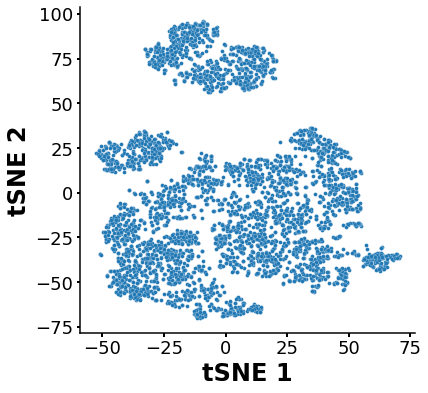

In [19]:
smiles = table["smiles"]
smi=[Chem.MolFromSmiles(x) for x in smiles]
fps =  [MACCSkeys.GenMACCSKeys(x) for x in smi] # In this example I'll use MACCSKeys
tanimoto_sim_mat_lower_triangle=GetTanimotoSimMat(fps) #This compute a similartity matrix between all the molecules
n_mol = len(fps)
similarity_matrix = np.ones([n_mol,n_mol])
i_lower= np.tril_indices(n=n_mol,m=n_mol,k=-1)
i_upper= np.triu_indices(n=n_mol,m=n_mol,k=1)
similarity_matrix[i_lower] = tanimoto_sim_mat_lower_triangle
similarity_matrix[i_upper] = similarity_matrix.T[i_upper] 
distance_matrix = np.subtract(1,similarity_matrix) #This is the similarity matrix of all vs all molecules in our table

TSNE_sim = TSNE(n_components=2,init='pca',random_state=90, angle = 0.3,perplexity=50).fit_transform(distance_matrix) #Remember to always tune the parameters acording your dataset!!
tsne_result = pd.DataFrame(data = TSNE_sim , columns=["TC1","TC2"]) # New table containing the tSNE results
# tsne_result.head(5) #A new table containing the tSNE results

plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(6,6))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result,s=15,linewidth=0.2,alpha=1)


plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')

plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')

plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
handles, labels = ax.get_legend_handles_labels()

#ax.legend(handles=handles[1:], labels=labels[1:])

#plt.legend(loc='lower right',frameon=False,prop={'size': 22},ncol=1)

# plt.tight_layout()
# plt.show()

### tSNE + K-means

In [20]:
range_n_clusters = range(2,10,1) # To explore the "best" number of cluster to clasify our molecules
silhouettes = pd.DataFrame(columns=['n_clusters','silhouette'])
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = kmeans.fit_predict(tsne_result[['TC1','TC2']])
    silhouette_avg = silhouette_score(tsne_result[['TC1','TC1']], cluster_labels)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg) #This will print the silhouette score, as higher as our data is better distributed inside the clusters
    silhouettes.loc[n_clusters,"silhouette"] = silhouette_avg

n_clusters = 8

kmeans = KMeans(n_clusters=8, random_state=10) # We define the best number of clusters (6)

clusters = kmeans.fit(tsne_result[['TC1','TC2']]) #TC1vs TC2

tsne_result['Cluster'] = pd.Series(clusters.labels_, index=tsne_result.index)
tsne_result['mol_id'] = table['mol_id'].astype(int)

# Agrego los comprados
purchased = [1325106,967261,1101762,1855308,1325841,73172,442024,364112,2141063,206554,1484355,1533212,352530,947132,1489528,2165262,1017337,352298,1293366,858876,1364981]
table_bought = tsne_result[tsne_result['mol_id'].astype(int).isin(purchased)]
table_bought


For n_clusters = 2 The average silhouette_score is : 0.010758112
For n_clusters = 3 The average silhouette_score is : 0.21180616
For n_clusters = 4 The average silhouette_score is : 0.13172297
For n_clusters = 5 The average silhouette_score is : -0.051343277
For n_clusters = 6 The average silhouette_score is : -0.029810986
For n_clusters = 7 The average silhouette_score is : -0.06102482
For n_clusters = 8 The average silhouette_score is : -0.07756366
For n_clusters = 9 The average silhouette_score is : -0.10365725


TC1        TC2  Cluster   mol_id
19   -47.725189  21.754389        7   206554
36   -24.080486 -35.802227        3  1017337
2883  -3.513335  88.626991        2  1325106
2884 -38.365192  27.073084        7  1325841
2896 -44.487427  23.494310        7  1533212
2898 -45.726234  13.150835        7  1855308
2920 -23.577440 -33.981297        3  1489528
2928 -28.334743  27.005051        7   364112
2968 -31.312361  76.972000        2  2165262
2985 -28.212439  26.735565        7   442024
2991 -32.211082  18.812876        7   967261
2993 -36.058037  29.711004        7  1101762
2999 -38.097996 -54.204765        3  1293366
3875 -45.200855 -29.190556        3  1364981
3899 -27.550591 -53.659382        4   947132
3930 -34.964619  32.607780        7    73172
3932 -43.573635  14.342629        7  2141063
3957 -32.958584  17.003145        7  1484355
3976 -37.526283 -50.133533        3   352298
3978 -37.577248 -50.172871        3   352530
3983 -36.543903 -45.788456        3   858876

In [36]:
table_bought

TC1        TC2  Cluster   mol_id
19   -47.725189  21.754389        7   206554
36   -24.080486 -35.802227        3  1017337
2883  -3.513335  88.626991        2  1325106
2884 -38.365192  27.073084        7  1325841
2896 -44.487427  23.494310        7  1533212
2898 -45.726234  13.150835        7  1855308
2920 -23.577440 -33.981297        3  1489528
2928 -28.334743  27.005051        7   364112
2968 -31.312361  76.972000        2  2165262
2985 -28.212439  26.735565        7   442024
2991 -32.211082  18.812876        7   967261
2993 -36.058037  29.711004        7  1101762
2999 -38.097996 -54.204765        3  1293366
3875 -45.200855 -29.190556        3  1364981
3899 -27.550591 -53.659382        4   947132
3930 -34.964619  32.607780        7    73172
3932 -43.573635  14.342629        7  2141063
3957 -32.958584  17.003145        7  1484355
3976 -37.526283 -50.133533        3   352298
3978 -37.577248 -50.172871        3   352530
3983 -36.543903 -45.788456        3   858876

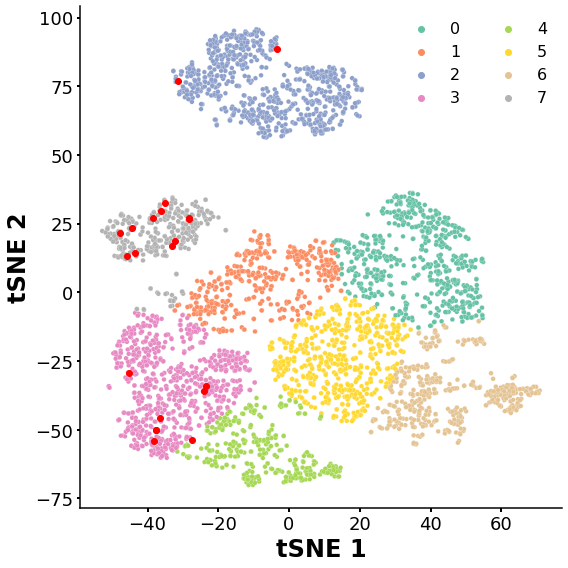

In [37]:
plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(8,8))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result, hue='Cluster',s=22,palette=sns.color_palette("Set2", 8),linewidth=0.2,alpha=1)

ax.plot(table_bought["TC1"],table_bought["TC2"], "or")

#for label in purchased : 
#    plt.annotate(str(label), (table_bought[table_bought["mol_id"]==label].TC1, table_bought[table_bought["mol_id"]==label].TC2))
        

plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')
plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')
plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles[1:], labels=labels[1:])

plt.legend(loc='best',frameon=False,prop={'size': 16},ncol=2)

plt.tight_layout()
plt.savefig('tsne-clusters-w-anottation.png')
plt.show()


### Hierarchichal

In [22]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from sklearn.manifold import TSNE
import pickle, sys
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

library = ndpi_available_cherry.copy()
# library["fps"] = library.apply(lambda x: Chem.Fingerprints.FingerprintMols.FingerprintMol(x["mol"]), axis=1)

size=len(library)
hmap=np.empty(shape=(size,size))

hmapx = np.array(distance_matrix)
linked = linkage(distance_matrix, method='single')
labelList = ndpi_available_cherry["mol_id"]


C:\Users\lioneluranl\AppData\Local\Temp\ipykernel_17388\2948833702.py:19: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='single')


mol_id                                             smiles  \
0        4933            CN1CCc2c([C@H](C1)c1ccccc1)cc(c(c2)Cl)O   
1       20851                         N1CCN(CC1)c1ccc2c(c1)cccc2   
2       23080                    CN(CCc1ccc(c(c1)Cl)Cl)CCN1CCCC1   
3       33241  COc1ccc2c(c1)CCC(=C2c1ccc(cc1)OCCN1CCCC1)c1ccccc1   
4       38412  Fc1ccc(cc1)C(c1ccc(cc1)F)OCCN1CCN(CC1)C/C=C/c1...   
...       ...                                                ...   
4036  2255383  OC(=Nc1ccc(c(c1)N(C)C)C)C1CCN(CC1)S(=O)(=O)c1n...   
4037  2257262  COc1ccc(cc1Cl)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)...   
4038  2258752  OC(=NCCCc1ccccc1)C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   
4039  2258871  O=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(C)C)Nc1ccc(c...   
4040  2260017  COc1ccc(cc1)CN=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   

         known_target                               known_target_product  \
0     ENSG00000147955          sigma non-opioid intracellular receptor 1   
1     ENSG00000147955          sigma non-opioid intracellular receptor 1   
2     ENSG00000147955          sigma non-opioid intracellular receptor 1   
3     ENSG00000147955          sigma non-opioid intracellular receptor 1   
4     ENSG00000147955          sigma non-opioid intracellular receptor 1   
...               ...                                                ...   
4036           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4037           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4038           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4039           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4040           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   

     known_target_species         gene_name        omcl  nds_tier  \
0                     hsa   TcCLB.510329.90  OG5_131051         5   
1                     hsa   TcCLB.510329.90  OG5_131051         5   
2                     hsa   TcCLB.510329.90  OG5_131051         5   
3                     hsa   TcCLB.510329.90  OG5_131051         5   
4                     hsa   TcCLB.510329.90  OG5_131051         5   
...                   ...               ...         ...       ...   
4036                  mtu  TcCLB.507089.270  OG5_126968         4   
4037                  mtu  TcCLB.507089.270  OG5_126968         4   
4038                  mtu  TcCLB.507089.270  OG5_126968         4   
4039                  mtu  TcCLB.507089.270  OG5_126968         4   
4040                  mtu  TcCLB.507089.270  OG5_126968         4   

                             gene_product_x  \
0            C-8 sterol isomerase, putative   
1            C-8 sterol isomerase, putative   
2            C-8 sterol isomerase, putative   
3            C-8 sterol isomerase, putative   
4            C-8 sterol isomerase, putative   
...                                     ...   
4036  dihydrolipoyl dehydrogenase, putative   
4037  dihydrolipoyl dehydrogenase, putative   
4038  dihydrolipoyl dehydrogenase, putative   
4039  dihydrolipoyl dehydrogenase, putative   
4040  dihydrolipoyl dehydrogenase, putative   

                                                    mol  \
0     <img data-content="rdkit/molecule" src="data:i...   
1     <img data-content="rdkit/molecule" src="data:i...   
2     <img data-content="rdkit/molecule" src="data:i...   
3     <img data-content="rdkit/molecule" src="data:i...   
4     <img data-content="rdkit/molecule" src="data:i...   
...                                                 ...   
4036  <img data-content="rdkit/molecule" src="data:i...   
4037  <img data-content="rdkit/molecule" src="data:i...   
4038  <img data-content="rdkit/molecule" src="data:i...   
4039  <img data-content="rdkit/molecule" src="data:i...   
4040  <img data-content="rdkit/molecule" src="data:i...   

                                                  inchi  \
0     InChI=1S/C17H18ClNO/c1-19-8-7-13-9-16(18)17(20...   
1     InChI=1S/C14H16N2/c1-2-4-13-11-14(6-5-12(13)3-... 
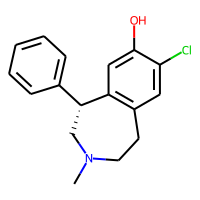
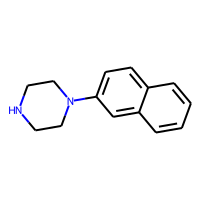
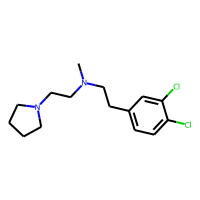
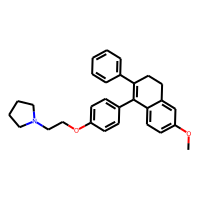
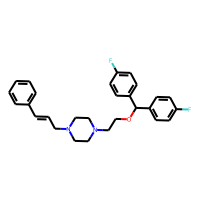
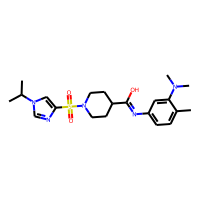
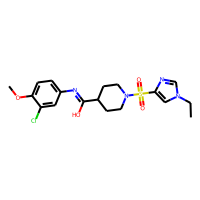
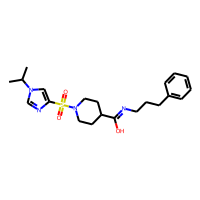
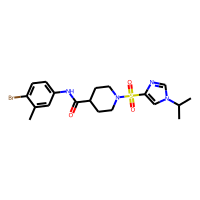
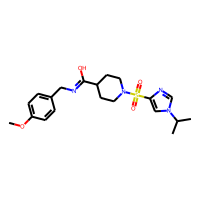

In [23]:
t=0.8
clusters = fcluster(linked, t,criterion="distance")
molclusters = pd.DataFrame({'mol_id': labelList, 'cluster': clusters })
clusters_agg = molclusters.groupby(['cluster']).agg(['count'])
# clusters_agg

ndpi_available_cherry_wclusters = pd.merge(library,molclusters,on="mol_id")

ndpi_available_cherry_wclusters

mol_id                                             smiles  \
0        4933            CN1CCc2c([C@H](C1)c1ccccc1)cc(c(c2)Cl)O   
1       20851                         N1CCN(CC1)c1ccc2c(c1)cccc2   
2       23080                    CN(CCc1ccc(c(c1)Cl)Cl)CCN1CCCC1   
3       33241  COc1ccc2c(c1)CCC(=C2c1ccc(cc1)OCCN1CCCC1)c1ccccc1   
4       38412  Fc1ccc(cc1)C(c1ccc(cc1)F)OCCN1CCN(CC1)C/C=C/c1...   
...       ...                                                ...   
4036  2245430  OC(=Nc1ccc2c(c1)OCCO2)C1CCN(CC1)S(=O)(=O)c1ncn...   
4037  2245828  Brc1cccc(c1)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(...   
4038  2257262  COc1ccc(cc1Cl)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)...   
4039  2258871  O=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(C)C)Nc1ccc(c...   
4040  2260017  COc1ccc(cc1)CN=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   

         known_target                               known_target_product  \
0     ENSG00000147955          sigma non-opioid intracellular receptor 1   
1     ENSG00000147955          sigma non-opioid intracellular receptor 1   
2     ENSG00000147955          sigma non-opioid intracellular receptor 1   
3     ENSG00000147955          sigma non-opioid intracellular receptor 1   
4     ENSG00000147955          sigma non-opioid intracellular receptor 1   
...               ...                                                ...   
4036           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4037           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4038           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4039           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4040           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   

     known_target_species         gene_name        omcl  nds_tier  \
0                     hsa   TcCLB.510329.90  OG5_131051         5   
1                     hsa   TcCLB.510329.90  OG5_131051         5   
2                     hsa   TcCLB.510329.90  OG5_131051         5   
3                     hsa   TcCLB.510329.90  OG5_131051         5   
4                     hsa   TcCLB.510329.90  OG5_131051         5   
...                   ...               ...         ...       ...   
4036                  mtu  TcCLB.507089.270  OG5_126968         4   
4037                  mtu  TcCLB.507089.270  OG5_126968         4   
4038                  mtu  TcCLB.507089.270  OG5_126968         4   
4039                  mtu  TcCLB.507089.270  OG5_126968         4   
4040                  mtu  TcCLB.507089.270  OG5_126968         4   

                             gene_product_x  \
0            C-8 sterol isomerase, putative   
1            C-8 sterol isomerase, putative   
2            C-8 sterol isomerase, putative   
3            C-8 sterol isomerase, putative   
4            C-8 sterol isomerase, putative   
...                                     ...   
4036  dihydrolipoyl dehydrogenase, putative   
4037  dihydrolipoyl dehydrogenase, putative   
4038  dihydrolipoyl dehydrogenase, putative   
4039  dihydrolipoyl dehydrogenase, putative   
4040  dihydrolipoyl dehydrogenase, putative   

                                                    mol  \
0     <img data-content="rdkit/molecule" src="data:i...   
1     <img data-content="rdkit/molecule" src="data:i...   
2     <img data-content="rdkit/molecule" src="data:i...   
3     <img data-content="rdkit/molecule" src="data:i...   
4     <img data-content="rdkit/molecule" src="data:i...   
...                                                 ...   
4036  <img data-content="rdkit/molecule" src="data:i...   
4037  <img data-content="rdkit/molecule" src="data:i...   
4038  <img data-content="rdkit/molecule" src="data:i...   
4039  <img data-content="rdkit/molecule" src="data:i...   
4040  <img data-content="rdkit/molecule" src="data:i...   

                                                  inchi  \
0     InChI=1S/C17H18ClNO/c1-19-8-7-13-9-16(18)17(20...   
1     InChI=1S/C14H16N2/c1-2-4-13-11-14(6-5-12(13)3-... 
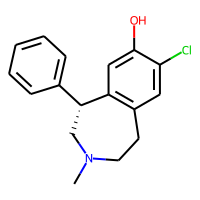
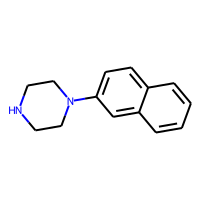
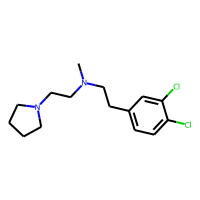
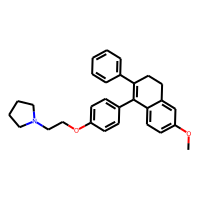
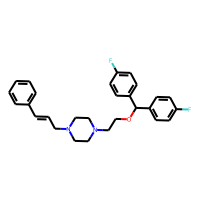
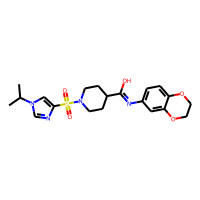
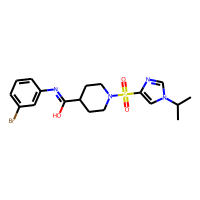
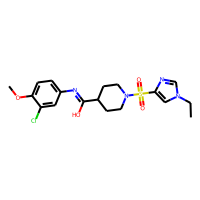
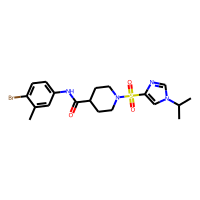
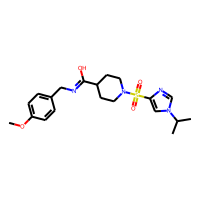

In [24]:
clusters_count = ndpi_available_cherry_wclusters.groupby(['cluster'])["mol_id"].agg(['count'])
clusters_count = clusters_count.reset_index()
clusters_count = clusters_count[clusters_count["count"]<10]

# Remove no big, sparse clusters
ndpi_available_cherry_wclusters = ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters["cluster"].isin(clusters_count["cluster"])]
ndpi_available_cherry_wclusters = pd.merge(ndpi_available_cherry_wclusters,clusters_count, how="outer", on="cluster")
ndpi_available_cherry_wclusters

[(0.0, 15.0)]

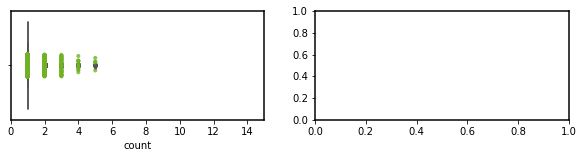

In [25]:
ndpi_available_cherry_wclusters_min = ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters["count"]<5]


fig, axs = plt.subplots(1,2,figsize=(10,2))
g = sns.stripplot(data=ndpi_available_cherry_wclusters, x='count', ax=axs[0], size=4, color="#71b225", linewidth=0, alpha=0.8)
g = sns.boxplot(data=ndpi_available_cherry_wclusters, x='count', ax=axs[0], color="#f38a22")
g.set(xlim=(0,15))


#g2 = sns.boxplot(data=mds, x='cluster', ax=axs[1])
#g2.set(xlim=(60,3000))

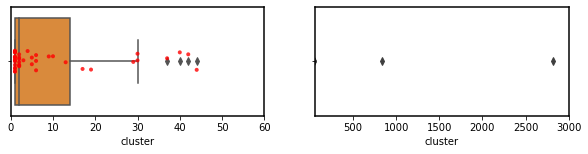

In [26]:
mds_check = ndpi_available_cherry_wclusters.copy()
mds = mds_check.groupby(['gene_name'],as_index=False).agg({'cluster': 'count'})

fig, axs = plt.subplots(1,2,figsize=(10,2))
g = sns.stripplot(data=mds, x='cluster', ax=axs[0], size=4, color="red", linewidth=0, alpha=0.8)
g = sns.boxplot(data=mds, x='cluster', ax=axs[0], color="#f38a22")
g.set(xlim=(0,60))


g2 = sns.boxplot(data=mds, x='cluster', ax=axs[1])
g2.set(xlim=(60,3000))


# threshold = (np.percentile(mds["cluster"], 80))
# plt.axvline(threshold,color="red",linestyle="--")
# plt.xlim((0, 50))   # set the xlim to left, right

plt.savefig("outliers.pdf")



mol_id                                             smiles  \
0        4933            CN1CCc2c([C@H](C1)c1ccccc1)cc(c(c2)Cl)O   
1       20851                         N1CCN(CC1)c1ccc2c(c1)cccc2   
2       23080                    CN(CCc1ccc(c(c1)Cl)Cl)CCN1CCCC1   
3       33241  COc1ccc2c(c1)CCC(=C2c1ccc(cc1)OCCN1CCCC1)c1ccccc1   
4       38412  Fc1ccc(cc1)C(c1ccc(cc1)F)OCCN1CCN(CC1)C/C=C/c1...   
...       ...                                                ...   
4036  2245430  OC(=Nc1ccc2c(c1)OCCO2)C1CCN(CC1)S(=O)(=O)c1ncn...   
4037  2245828  Brc1cccc(c1)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(...   
4038  2257262  COc1ccc(cc1Cl)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)...   
4039  2258871  O=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(C)C)Nc1ccc(c...   
4040  2260017  COc1ccc(cc1)CN=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   

         known_target                               known_target_product  \
0     ENSG00000147955          sigma non-opioid intracellular receptor 1   
1     ENSG00000147955          sigma non-opioid intracellular receptor 1   
2     ENSG00000147955          sigma non-opioid intracellular receptor 1   
3     ENSG00000147955          sigma non-opioid intracellular receptor 1   
4     ENSG00000147955          sigma non-opioid intracellular receptor 1   
...               ...                                                ...   
4036           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4037           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4038           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4039           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
4040           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   

     known_target_species         gene_name        omcl  nds_tier  \
0                     hsa   TcCLB.510329.90  OG5_131051         5   
1                     hsa   TcCLB.510329.90  OG5_131051         5   
2                     hsa   TcCLB.510329.90  OG5_131051         5   
3                     hsa   TcCLB.510329.90  OG5_131051         5   
4                     hsa   TcCLB.510329.90  OG5_131051         5   
...                   ...               ...         ...       ...   
4036                  mtu  TcCLB.507089.270  OG5_126968         4   
4037                  mtu  TcCLB.507089.270  OG5_126968         4   
4038                  mtu  TcCLB.507089.270  OG5_126968         4   
4039                  mtu  TcCLB.507089.270  OG5_126968         4   
4040                  mtu  TcCLB.507089.270  OG5_126968         4   

                             gene_product_x  \
0            C-8 sterol isomerase, putative   
1            C-8 sterol isomerase, putative   
2            C-8 sterol isomerase, putative   
3            C-8 sterol isomerase, putative   
4            C-8 sterol isomerase, putative   
...                                     ...   
4036  dihydrolipoyl dehydrogenase, putative   
4037  dihydrolipoyl dehydrogenase, putative   
4038  dihydrolipoyl dehydrogenase, putative   
4039  dihydrolipoyl dehydrogenase, putative   
4040  dihydrolipoyl dehydrogenase, putative   

                                                    mol  \
0     <img data-content="rdkit/molecule" src="data:i...   
1     <img data-content="rdkit/molecule" src="data:i...   
2     <img data-content="rdkit/molecule" src="data:i...   
3     <img data-content="rdkit/molecule" src="data:i...   
4     <img data-content="rdkit/molecule" src="data:i...   
...                                                 ...   
4036  <img data-content="rdkit/molecule" src="data:i...   
4037  <img data-content="rdkit/molecule" src="data:i...   
4038  <img data-content="rdkit/molecule" src="data:i...   
4039  <img data-content="rdkit/molecule" src="data:i...   
4040  <img data-content="rdkit/molecule" src="data:i...   

                                                  inchi  \
0     InChI=1S/C17H18ClNO/c1-19-8-7-13-9-16(18)17(20...   
1     InChI=1S/C14H16N2/c1-2-4-13-11-14(6-5-12(13)3-... 
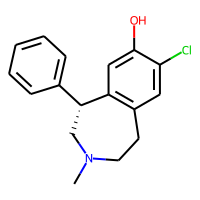
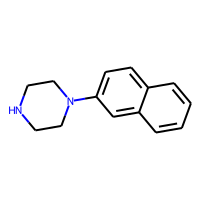
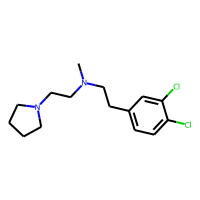
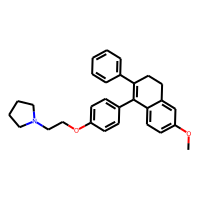
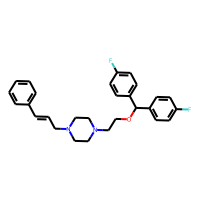
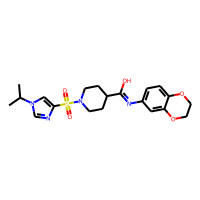
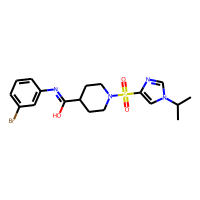
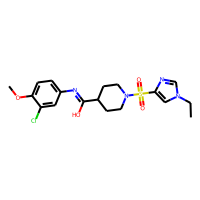
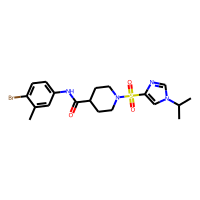
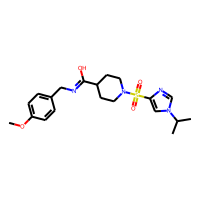

In [27]:
mds_genes = mds[mds["cluster"] < 50]["gene_name"]
library_min = ndpi_available_cherry_wclusters[ndpi_available_cherry_wclusters["gene_name"].isin( mds_genes)]
library_min

In [28]:
library_min = library_min[['mol_id', 'smiles','known_target', 'known_target_product',
       'known_target_species', 'gene_name',
        'mol', 'inchi', 'inchikey', 'Link', 'provider', 'cluster',
        'count']]
library_min = pd.merge(library_min,tcr_targets_full,how="inner",on="gene_name")
library_min.mol_id.unique

<bound method Series.unique of 0         4933
1        20851
2        23080
3        33241
4        38412
        ...   
380    2245430
381    2245828
382    2257262
383    2258871
384    2260017
Name: mol_id, Length: 385, dtype: int64>

## Library Assembly

In [29]:
library_min["mol"] = library_min.apply(lambda x : Chem.MolFromSmiles(x["smiles"]),axis=1)        

In [30]:
from rdkit.Chem import Draw

m = []

for i, mol in library_min.iterrows() :    

    m.append(Draw.MolToImage(mol["mol"], size=(300, 300)))
        
library_min["mol_thumb"] = m

In [31]:
def matchesSubstructure(mols : list , scaffolds : list) :     
    matches = []
    for mol in mols :
        for scaffold in scaffolds :         
            matches = mol.GetSubstructMatches(safe_molFromSmiles(scaffold))
            if len(matches) > 0 :
                return True
    
    return False

mol_id                                             smiles  \
0       4933            CN1CCc2c([C@H](C1)c1ccccc1)cc(c(c2)Cl)O   
1      20851                         N1CCN(CC1)c1ccc2c(c1)cccc2   
2      23080                    CN(CCc1ccc(c(c1)Cl)Cl)CCN1CCCC1   
3      33241  COc1ccc2c(c1)CCC(=C2c1ccc(cc1)OCCN1CCCC1)c1ccccc1   
4      38412  Fc1ccc(cc1)C(c1ccc(cc1)F)OCCN1CCN(CC1)C/C=C/c1...   
..       ...                                                ...   
380  2245430  OC(=Nc1ccc2c(c1)OCCO2)C1CCN(CC1)S(=O)(=O)c1ncn...   
381  2245828  Brc1cccc(c1)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(...   
382  2257262  COc1ccc(cc1Cl)N=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)...   
383  2258871  O=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C(C)C)Nc1ccc(c...   
384  2260017  COc1ccc(cc1)CN=C(C1CCN(CC1)S(=O)(=O)c1ncn(c1)C...   

        known_target                               known_target_product  \
0    ENSG00000147955          sigma non-opioid intracellular receptor 1   
1    ENSG00000147955          sigma non-opioid intracellular receptor 1   
2    ENSG00000147955          sigma non-opioid intracellular receptor 1   
3    ENSG00000147955          sigma non-opioid intracellular receptor 1   
4    ENSG00000147955          sigma non-opioid intracellular receptor 1   
..               ...                                                ...   
380           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
381           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
382           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
383           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   
384           Rv0462  Dihydrolipoamide dehydrogenase LpdC (lipoamide...   

    known_target_species         gene_name  \
0                    hsa   TcCLB.510329.90   
1                    hsa   TcCLB.510329.90   
2                    hsa   TcCLB.510329.90   
3                    hsa   TcCLB.510329.90   
4                    hsa   TcCLB.510329.90   
..                   ...               ...   
380                  mtu  TcCLB.507089.270   
381                  mtu  TcCLB.507089.270   
382                  mtu  TcCLB.507089.270   
383                  mtu  TcCLB.507089.270   
384                  mtu  TcCLB.507089.270   

                                                   mol  \
0    <img data-content="rdkit/molecule" src="data:i...   
1    <img data-content="rdkit/molecule" src="data:i...   
2    <img data-content="rdkit/molecule" src="data:i...   
3    <img data-content="rdkit/molecule" src="data:i...   
4    <img data-content="rdkit/molecule" src="data:i...   
..                                                 ...   
380  <img data-content="rdkit/molecule" src="data:i...   
381  <img data-content="rdkit/molecule" src="data:i...   
382  <img data-content="rdkit/molecule" src="data:i...   
383  <img data-content="rdkit/molecule" src="data:i...   
384  <img data-content="rdkit/molecule" src="data:i...   

                                                 inchi  \
0    InChI=1S/C17H18ClNO/c1-19-8-7-13-9-16(18)17(20...   
1    InChI=1S/C14H16N2/c1-2-4-13-11-14(6-5-12(13)3-...   
2    InChI=1S/C15H22Cl2N2/c1-18(10-11-19-7-2-3-8-19...   
3    InChI=1S/C29H31NO2/c1-31-26-14-16-28-24(21-26)...   
4    InChI=1S/C28H30F2N2O/c29-26-12-8-24(9-13-26)28...   
..                                                 ...   
380  InChI=1S/C20H26N4O5S/c1-14(2)23-12-19(21-13-23...   
381  InChI=1S/C18H23BrN4O3S/c1-13(2)22-11-17(20-12-...   
382  InChI=1S/C18H23ClN4O4S/c1-3-22-11-17(20-12-22)...   
383  InChI=1S/C19H25BrN4O3S/c1-13(2)23-11-18(21-12-...   
384  InChI=1S/C20H28N4O4S/c1-15(2)23-13-19(22-14-23...   

                        inchikey  \
0    GOTMKOSCLKVOGG-OAHLLOKOSA-N   
1    LWLBVIFUVSUSAY-UHFFFAOYSA-N   
2    ASGIQUHBAVIOTI-UHFFFAOYSA-N   
3    JEYWNNAZDLFBFF-UHFFFAOYSA-N   
4    DASHZBBQOARCMQ-QPJJXVBHSA-N   
..                           ...   
380  IDEIUDFOWKTJTP-UHFFFAOYSA-N   
381  CZBIXKYBCMNNQB-UHFFFAOYSA-N   
382  KDNBLVMUMSCJGG-UHFFFAOYS
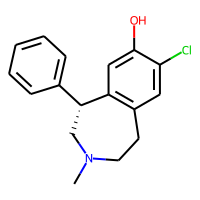
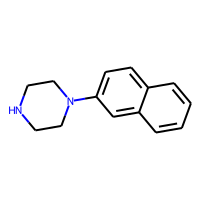
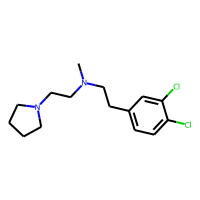
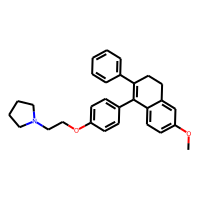
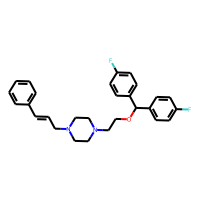
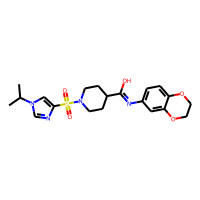
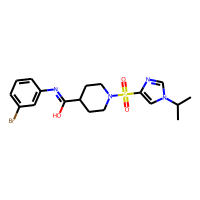
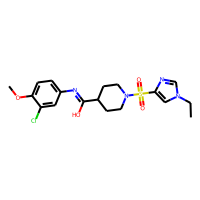
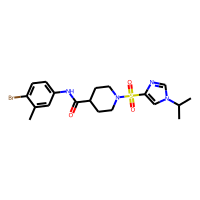
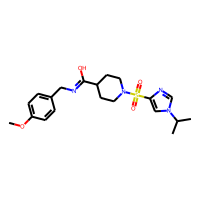

In [32]:
library= library_min.copy()
library

In [33]:
scaffolds = {
    'benzamidine' : ['NC(=O)C1=CC=CC=C1'],
    'sulfonamide' : ['NS(=O)(=O)C1=CC=CC=C1'],
    'picolinamide' : ['NC(=O)C1=CC=CC=N1'],
    'indole' : ['N1C=CC2=C1C=CC=C2'],
    'piperazine' : ['C1CNCCN1'],
    'morpholine' : ['C1COCCN1'],
    'azole' : ['N1C=CC=C1','N1C=CN=N1','C1N=CC=N1','N1C=CN=C1','N1C=NC=N1'],
    'pirrolone' : ['O=C1NCC=C1'],
    'thiazole' : ['S1C=CN=C1','S1C=CC=C1'],
    'oxazole' : ['O1C=CN=C1','O1C=CC=C1'],
    'furan' : ['O1C=CC=C1'],
    'napthalene_diimide' : ["O=C1NC(=O)C2=C3C(C=CC=C13)=CC=C2"],
    'chromenes' : ["C1C=COC2=C1C=CC=C2","O=C1C=COC2=C1C=CC=C2"],
    'benzothiazole' : ["S1C=NC2=C1C=CC=C2"],
    'thiazoleidine' : ["O=C1CSC(=S)N1"],
    'waltherione' : ['COC1=CC=CC2=C1NCCC2=O'],
    'adenine' : ['NC1=NC=NC2=C1NC=N2'],    
    'nitro' : ['O=N(=O)C1=CC=CC=C1']
}

In [38]:
collections = []

for scaffold_id, scaffold_mol in scaffolds.items() : 
    
    scaffold_lib = library_min.copy()
    #print(scaffold_lib)
    scaffold_lib["keeper"] = scaffold_lib.apply(lambda x: matchesSubstructure([x["mol"]],scaffold_mol),axis=1)
    scaffold_lib = scaffold_lib[scaffold_lib["keeper"]]
    scaffold_lib["scaffold"] = scaffold_id
    collections.append(scaffold_lib)
    print(f"Found {len(scaffold_lib)} with {scaffold_id} scaffold")

library_scaffolds = pd.concat(collections)[['cluster','mol_id','scaffold']]


Found 37 with benzamidine scaffold
Found 40 with sulfonamide scaffold
Found 0 with picolinamide scaffold
Found 7 with indole scaffold
Found 31 with piperazine scaffold
Found 30 with morpholine scaffold
Found 91 with azole scaffold
Found 16 with pirrolone scaffold
Found 49 with thiazole scaffold
Found 19 with oxazole scaffold
Found 12 with furan scaffold
Found 2 with napthalene_diimide scaffold
Found 9 with chromenes scaffold
Found 16 with benzothiazole scaffold
Found 1 with thiazoleidine scaffold
Found 0 with waltherione scaffold
Found 8 with adenine scaffold
Found 16 with nitro scaffold


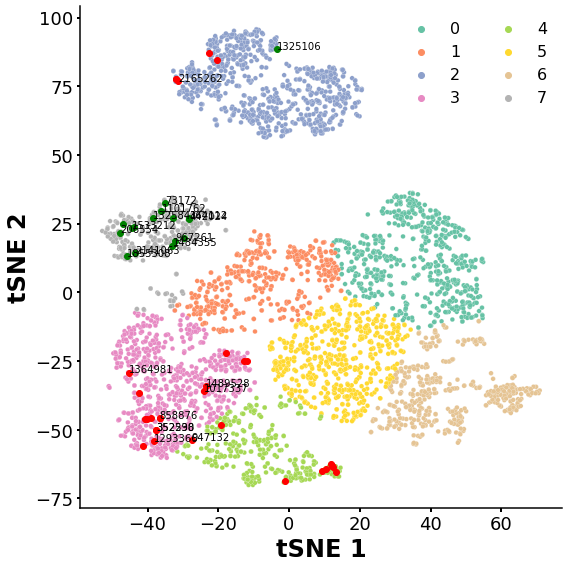

In [40]:
tsne_wscaffolds = pd.merge(tsne_result,library_scaffolds,on="mol_id")

plt.rcParams['axes.linewidth'] = 1.5
fig, ax = plt.subplots(figsize=(8,8))

ax=sns.scatterplot(x='TC1',y='TC2',data=tsne_result, hue='Cluster',s=22,palette=sns.color_palette("Set2", 8),linewidth=0.2,alpha=1)

# Plot nitrobenzenes
df_scaffold_nitro = tsne_wscaffolds[tsne_wscaffolds["scaffold"]=='nitro']
ax.plot(df_scaffold_nitro["TC1"],df_scaffold_nitro["TC2"], "og")

# Plot piperazines
df_scaffold_pip = tsne_wscaffolds[tsne_wscaffolds["scaffold"]=='piperazine']
ax.plot(df_scaffold_pip["TC1"],df_scaffold_pip["TC2"], "or")

for label in purchased : 
    plt.annotate(str(label), (table_bought[table_bought["mol_id"]==label].TC1, table_bought[table_bought["mol_id"]==label].TC2))
        

plt.xlabel ('tSNE 1',fontsize=24,fontweight='bold')
plt.ylabel ('tSNE 2',fontsize=24,fontweight='bold')
plt.tick_params ('both',width=2,labelsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles=handles[1:], labels=labels[1:])

plt.legend(loc='best',frameon=False,prop={'size': 16},ncol=2)

plt.tight_layout()
# plt.savefig('tsne-clusters-w-anottation.pdf')
plt.show()

## Export w/ image

In [1]:
collections = []

for scaffold_id, scaffold_mol in scaffolds.items() : 
    
    scaffold_lib = library.copy()
    #print(scaffold_lib)
    scaffold_lib["keeper"] = scaffold_lib.apply(lambda x: matchesSubstructure([x["mol"]],scaffold_mol),axis=1)
    scaffold_lib = scaffold_lib[scaffold_lib["keeper"]]
    scaffold_lib["scaffold"] = scaffold_id
    collections.append(scaffold_lib)
    print(f"Found {len(scaffold_lib)} with {scaffold_id} scaffold")

    libraryExport = HTML(scaffold_lib[["mol_id","cluster","gene_name","gene_product","mol_thumb","Link"]].to_html(formatters={'mol_id':set_formatter,'mol_thumb': image_formatter, "Link":link_formatter}, escape=False))

    with open(f'libraryAgg_{scaffold_id}.html', 'w') as f:
        f.write(libraryExport.data)
        f.close()
        
resto = library[~library["cluster"].isin(list(pd.concat(collections)["cluster"]))]
print(f"{len(resto)} left with no specific scaffold")
libraryExport = HTML(resto[["mol_id",'smiles',"cluster","gene_name","gene_product","Link"]].to_html(formatters={'mol_id':set_formatter,'mol_thumb': image_formatter, "Link":link_formatter}, escape=False))
with open(f'libraryAgg_resto.html', 'w') as f:
    f.write(libraryExport.data)
    f.close()


In [ ]:
# library.rename(columns={"gene_product_x" : "gene_product"}, inplace=True)
target_for_purchased_compounds = library[library["mol_id"].isin(purchased)].gene_name
purchased_library = library[library['gene_name'].isin(target_for_purchased_compounds)]
purchased_library


In [ ]:
purchased_smiles = library[library["mol_id"].isin(purchased)][["mol_id","smiles"]]

In [ ]:
pd.set_option('display.max_colwidth', None)
purchased_smiles

mol_id  \
19    206554   
36   1017337   
63   1364981   
87    442024   
93    967261   
95   1101762   
100  1293366   
126  1484355   
152  1325106   
153  1325841   
164  1533212   
166  1855308   
190  1489528   
198   364112   
238  2165262   
250   858876   
281   947132   
306    73172   
308  2141063   
336   352298   
337   352530   

                                                                           smiles  
19                                      O=C(N(CCN1CCCC1)C)Cc1cccc(c1)[N+](=O)[O-]  
36                            N#Cc1ccc(cc1)CNC(=O)CCCCCN1CCN(CC1)c1ccccc1c1ccccc1  
63            OCCN1CCN(CC1)C(=O)CSc1nnc(n1c1ccccc1)CCCn1c(=O)c2cccc3c2c(c1=O)ccc3  
87                              N=C1NC(=O)/C(=C/c2ccc(o2)c2ccccc2[N+](=O)[O-])/S1  
93                 S=C(NC(=O)c1ccc(cc1)[N+](=O)[O-])Nc1ccc(c(c1)c1nc2c(s1)cccc2)O  
95                               [O-][N+](=O)c1cc2c(O)cccc2c2c1c(cc1c2OCO1)C(=O)O  
100                                     COc1cc(cc(c1OC)OC)C(=O)N1CCN(CC1)c1ccccn1  
126                      [O-][N+](=O)c1cc(OCC(F)(F)F)c2c(c1)sn(c2=O)c1cccc(c1C)Cl  
152                         O=C(c1cccc(c1)[N+](=O)[O-])Nc1nnc(s1)S(=O)(=O)N1CCCC1  
153                    O=C(C1CC1(c1cccc(c1)C)c1cccc(c1)C)Nc1ccc(cc1O)[N+](=O)[O-]  
164                          O=C(Nc1ccccc1Cl)CCC(=O)OCC(=O)c1ccc(cc1)[N+](=O)[O-]  
166                       CCc1ccc(cc1)OCC(=O)N/N=C/c1cc(ccc1N1CCOCC1)[N+](=O)[O-]  
190                                            Clc1ccc2c(c1)nccc2N1CCN(CC1)C(=O)C  
198                         S=C1NC(=O)/C(=C/c2ccc(o2)c2ccc(cc2Br)[N+](=O)[O-])/S1  
238  COc1ncc(cc1NS(=O)(=O)c1ccc(cc1F)F)c1ccc2c(c1)c(ccn2)C#CCN1CCN(CC1)S(=O)(=O)C  
250                                     O=C1C(=O)c2c(N1CN1CCN(CC1)Cc1ccccc1)cccc2  
281                       O=C(N1CCN(CC1)Cc1cccc(c1)Oc1ccccc1)OC(C(F)(F)F)C(F)(F)F  
306                                      O=C1C(=O)c2ccccc2c2c1cc(cc2)[N+](=O)[O-]  
308                      COCCn1c2nc3ccccc3nc2c(c1NC(=O)c1cccc(c1)[N+](=O)[O-])C#N  
336                                  Oc1ccc(cc1)N1CCN(CC1)C1CC(=O)N(C1=O)c1ccccc1  
337                                 Oc1ccc(cc1)N1CCN(CC1)C1CC(=O)N(C1=O)Cc1ccccc1

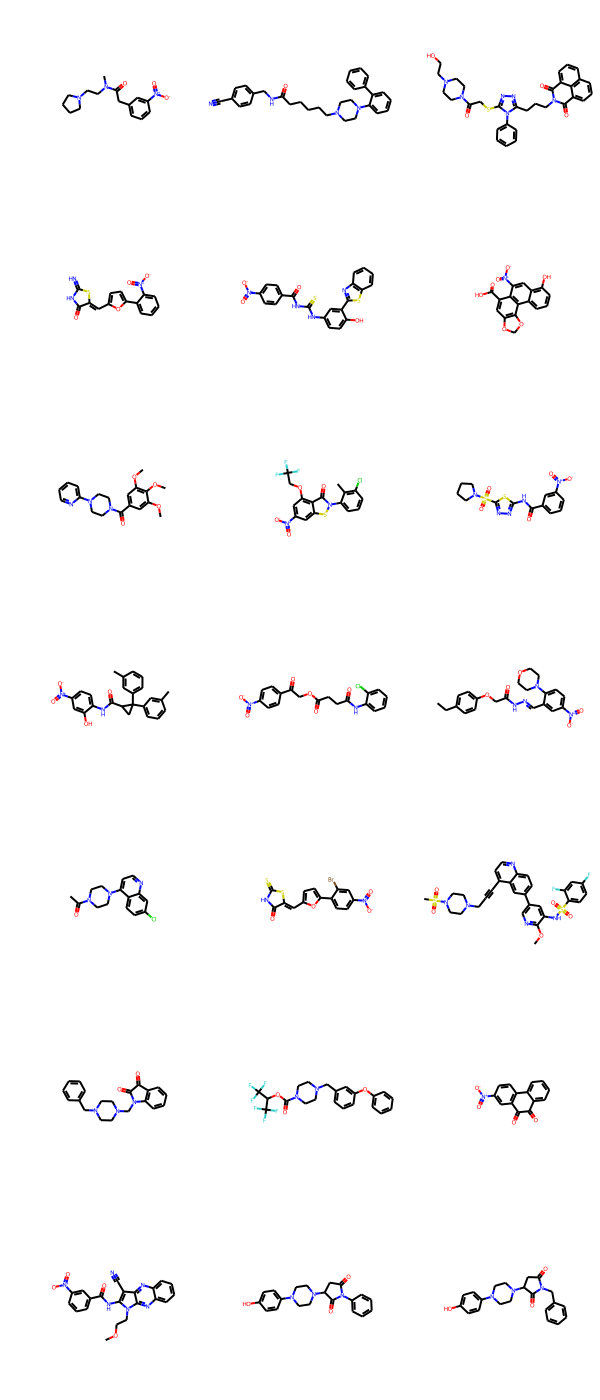

In [ ]:
img = Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in purchased_smiles]) 
img

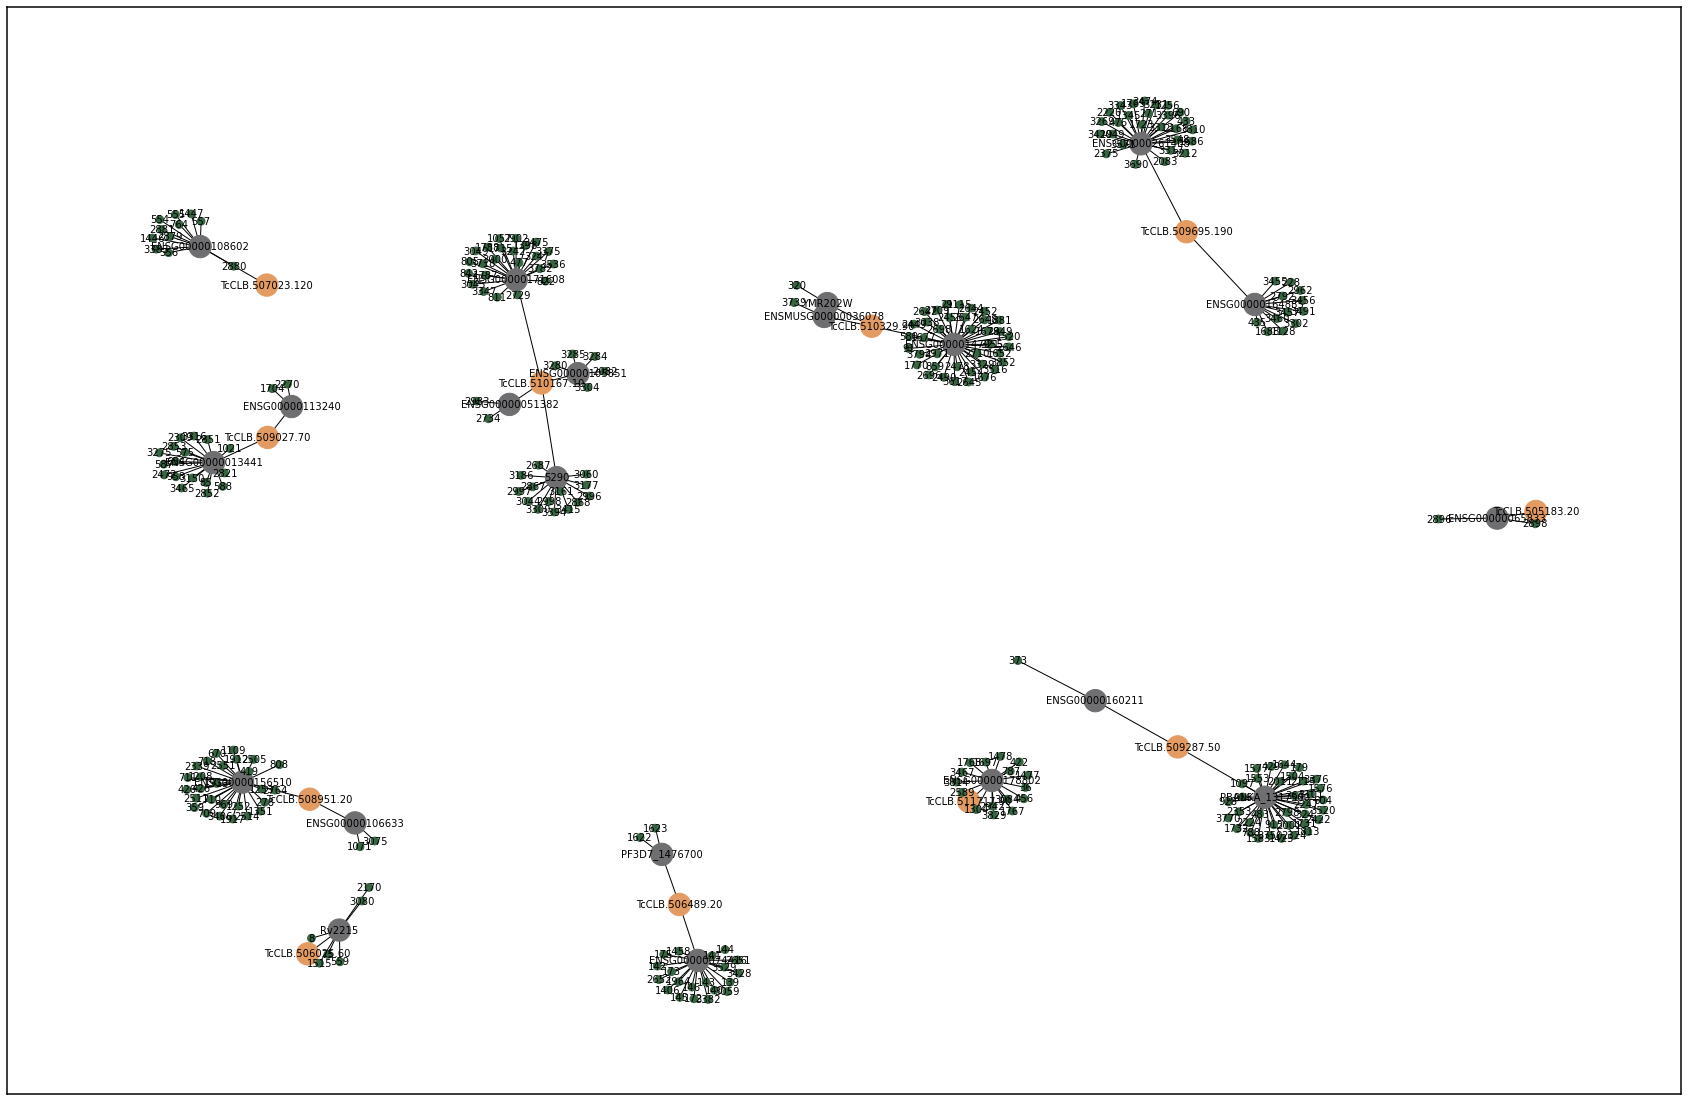

In [ ]:
import networkx as nx
import re 


G = nx.Graph()

for index, row in purchased_library.iterrows() : 

    known_target = row.known_target
    known_target_species = row.known_target_species
    tcr_target = row.gene_name
    tcr_product = row.gene_product
    cluster = row.cluster
    mols = res = row.mol_id

    # Nodes
    G.add_node(known_target, type='target', species='tcr', color="#6f6f72",size=500)
    
    G.add_node(tcr_target, type='target', species=known_target_species, color='#e39b62', size=500)

    G.add_node(cluster, type='drug', mol=mols, color= '#386643', size=60 )

    # T2T Edge
    G.add_edge(known_target,tcr_target,length="1")

    # D2T Edge
    G.add_edge(known_target,cluster,length="1000")


fig, axs = plt.subplots(figsize=(30,20))

pos = nx.spring_layout(G) # positions for all nodes

color_map = []
size_map = []

for node, data in G.nodes(data=True): 
    color_map.append(data['color'])
    size_map.append(data['size'])

# nodes    
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=size_map)

# edges
nx.draw_networkx_edges(G,pos,width=1)

plt.savefig("graph-no-labels-purchased.svg")

# Labels
nx.draw_networkx_labels(G,pos,font_size=10,font_family='sans-serif')

plt.savefig("graph-purchased.svg")

plt.show() # display



## Target Diversity hits

In [ ]:
# hardcodeo los hits para relevar los targets putativos
hits_molids = [947132,2141063,1855308,1325841,1017337]
tsne_wscaffolds[tsne_wscaffolds["mol_id"].isin(hits_molids)]

TC1        TC2  cluster_x   mol_id  cluster_y     scaffold
16  -24.080486 -35.802227          3  1017337       2449   piperazine
47  -38.365192  27.073084          7  1325841       2001        nitro
59  -45.726234  13.150835          7  1855308       1504   morpholine
60  -45.726234  13.150835          7  1855308       1504        nitro
253 -27.550591 -53.659382          4   947132       3059   piperazine
280 -43.573635  14.342629          7  2141063       1515  benzamidine
281 -43.573635  14.342629          7  2141063       1515        azole
282 -43.573635  14.342629          7  2141063       1515        nitro